In [1]:
import json
from langchain_core.messages import ToolMessage, SystemMessage
from langchain_core.runnables import RunnableConfig
import streamlit as st
import pandas as pd


from typing import (
    Annotated,
    Sequence,
    TypedDict,
    Optional
)
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

from langchain_openai import ChatOpenAI
from langchain_core.tools import tool

from chatbot import tools

model = ChatOpenAI(model="gpt-4o", temperature=0.7, api_key=st.secrets["OPENAI_API_KEY"])

tools_by_name = {tool.name: tool for tool in tools}
model = model.bind_tools(tools)

[03:50:22 -0500] [INFO]: NetworkX-cuGraph is unavailable: No module named 'cupy'.


In [2]:
#from langgraph.graph. there are graph, message, state

In [3]:

class AgentState(TypedDict):
    """The state of the agent."""
    # add_messages is a reducer
    # See https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers
    messages: Annotated[Sequence[BaseMessage], add_messages]
    question: str
    # graph_name: Optional[str]  # The selected graph name
    G_adb: Optional[object]  # The ArangoDB graph object
    df: Optional[pd.DataFrame]  # The resulting (CPM, hits?) dataframe


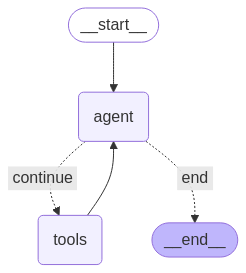

In [4]:

# Define our tool node
def tool_node(state: AgentState):
    """logic here"""
    outputs = []
    for tool_call in state["messages"][-1].tool_calls:
        print('STATE:', state)
        # print("TOOL CALL", tool_call)
        tool_name = tool_call["name"]

        if tool_name == "choose_graph":
            tool_result = tools_by_name[tool_call["name"]].invoke(tool_call["args"])
            # print("CHOOSE GRAPH GOT OUTPUT:", tool_result)
            outputs.append(
                ToolMessage(
                    # content=json.dumps(tool_result),
                    content = tool_result,
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
            return {'G_adb': tool_result, "messages": outputs}
        
        if tool_name == "create_cpm_table":
            G_adb = state["G_adb"]
            tool_result = tools_by_name[tool_call["name"]].invoke({"G_adb": G_adb})
            outputs.append(
                ToolMessage(
                    content=tool_result,
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
            return {'df': tool_result, "messages": outputs}
        
        if tool_name == "ask_cpm_question":
            cpm_df = state["df"]
            tool_result = tools_by_name[tool_call["name"]].invoke({"df": cpm_df, "question" :tool_call["args"]})
            outputs.append(
                ToolMessage(
                    content=tool_result,
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
            return {"messages": outputs}
        
        if tool_name == "create_hits_table":
            G_adb = state["G_adb"]
            tool_result = tools_by_name[tool_call["name"]].invoke({"G_adb": G_adb})
            outputs.append(
                ToolMessage(
                    content=tool_result,
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
            return {'df': tool_result, "messages": outputs}
        
        if tool_name == "ask_hits_question":
            hits_df = state["df"]
            tool_result = tools_by_name[tool_call["name"]].invoke({"df": hits_df, "question" :tool_call["args"]})
            outputs.append(
                ToolMessage(
                    content=tool_result,
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
            return {"messages": outputs}

# Define the node that calls the model
def call_model(
        state: AgentState,
        config: RunnableConfig,
    ):
    print("new state", state)
    """logic here"""
    # Get the question 
    system_prompt = SystemMessage(
        "You are a helpful AI assistant that will be querying in our graph databases. \
        A typical workflow will include: \
            - Going into the database to select the right graph \
            - Perform the calculation / analysis required to generate desired output in either natural language or a dataframe \
            - If necessary, further analyze the output dataframe to formulate answers to the user's question \
        "
    )
    response = model.invoke([system_prompt] + state["messages"], config)
    # We return a list, because this will get added to the existing list
    state["messages"] = [response]
    return state


# Define the conditional edge that determines whether to continue or not
def should_continue(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return "end"
    # Otherwise if there is, we continue
    else:
        return "continue"


from langgraph.graph import StateGraph, END

# Define a new graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.set_entry_point("agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
    # Finally we pass in a mapping.
    # The keys are strings, and the values are other nodes.
    # END is a special node marking that the graph should finish.
    # What will happen is we will call `should_continue`, and then the output of that
    # will be matched against the keys in this mapping.
    # Based on which one it matches, that node will then be called.
    {
        # If `tools`, then we call the tool node.
        "continue": "tools",
        # Otherwise we finish.
        "end": END,
    },
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("tools", "agent")

# Now we can compile and visualize our graph
graph = workflow.compile()

from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [5]:
# Helper function for formatting the stream nicely
def print_stream(stream):
    print(stream)
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

In [6]:
# inputs = {"messages": [("user", "what tasks should we do now?")]}
# print_stream(graph.stream(inputs, stream_mode="values"))

In [7]:
inputs = {"messages": [("user", "Tell me about employee 3 developement tendency")]}
print_stream(graph.stream(inputs, stream_mode="values"))

<generator object Pregel.stream at 0x160fc8610>
================================ Human Message =================================

Tell me about employee 3 developement tendency
================================== Ai Message ==================================
Tool Calls:
  choose_graph (call_hV9f7A3owsGIPFNw3msFWaQT)
 Call ID: call_hV9f7A3owsGIPFNw3msFWaQT
  Args:
    question: Tell me about employee 3 development tendency
STATE: {'messages': [HumanMessage(content='Tell me about employee 3 developement tendency', additional_kwargs={}, response_metadata={}, id='2379d73f-9a38-4354-bd2a-dfb1ceb71218'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_hV9f7A3owsGIPFNw3msFWaQT', 'function': {'arguments': '{"question":"Tell me about employee 3 development tendency"}', 'name': 'choose_graph'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 736, 'total_tokens': 758, 'completion_tokens_details': {'accepted_p

[03:50:33 -0500] [INFO]: Graph 'bi_team_task_assignment' exists.
[03:50:33 -0500] [INFO]: Default node type set to 'employee'


================================= Tool Message =================================
Name: choose_graph

DiGraph named 'bi_team_task_assignment' with 126 nodes and 156 edges
================================== Ai Message ==================================
Tool Calls:
  create_hits_table (call_PVBgcgy5RY8B2ZNAwzeOUhch)
 Call ID: call_PVBgcgy5RY8B2ZNAwzeOUhch
  Args:
    G_adb: bi_team_task_assignment
STATE: {'messages': [HumanMessage(content='Tell me about employee 3 developement tendency', additional_kwargs={}, response_metadata={}, id='2379d73f-9a38-4354-bd2a-dfb1ceb71218'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_hV9f7A3owsGIPFNw3msFWaQT', 'function': {'arguments': '{"question":"Tell me about employee 3 development tendency"}', 'name': 'choose_graph'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 736, 'total_tokens': 758, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audi

[03:50:39 -0500] [INFO]: Graph 'emp_interaction1' exists.
[03:50:39 -0500] [INFO]: Default node type set to 'emp_interaction1_node'
[03:50:43 -0500] [INFO]: Graph 'emp_interaction1' load took 3.414001226425171s


got hub and authority
                      EmpID  Hub_Score  Authority_Score
0  emp_interaction1_node/32  -0.000000         0.023740
1  emp_interaction1_node/17   0.032054         0.020483
2  emp_interaction1_node/16   0.011956         0.021253
3  emp_interaction1_node/29   0.013254         0.031120
4   emp_interaction1_node/0   0.061462        -0.000000
5  emp_interaction1_node/12   0.034545         0.015770
6  emp_interaction1_node/22   0.016141         0.033201
7  emp_interaction1_node/21   0.016532         0.034076
8  emp_interaction1_node/11   0.026512         0.006630
9  emp_interaction1_node/27   0.015068         0.062703
================================= Tool Message =================================
Name: create_hits_table

                       EmpID  Hub_Score  Authority_Score
0    emp_interaction1_node/0   0.061462        -0.000000
1    emp_interaction1_node/1   0.058762         0.006630
2    emp_interaction1_node/9   0.055764         0.023475
3    emp_interaction1_node/8

In [8]:
stop

NameError: name 'stop' is not defined

In [ ]:
# 5. Import the required modules

import networkx as nx
import nx_arangodb as nxadb

from arango import ArangoClient

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from random import randint
import re

from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from langchain_openai import ChatOpenAI
from langchain_community.graphs import ArangoGraph
from langchain_community.chains.graph_qa.arangodb import ArangoGraphQAChain
from langchain_core.tools import tool

import os
import networkx as nx
import nx_arangodb as nxadb

# os.environ["DATABASE_HOST"] = "https://b61c3b83bfe6.arangodb.cloud:8529"
# os.environ["DATABASE_USERNAME"] = "root"
# os.environ["DATABASE_PASSWORD"] = "RHr0KzkRUVlp61IisH8G"
# os.environ["DATABASE_NAME"] = "DAC_devops_log"

db = ArangoClient(hosts="https://b61c3b83bfe6.arangodb.cloud:8529") \
    .db(username="root", 
        password="RHr0KzkRUVlp61IisH8G", 
        name="DAC_devops_log",
        verify=True)

In [ ]:
G_adb = nxadb.DiGraph(
    name="emp_interaction1",
)

In [ ]:
nx.hits(G_adb)

In [ ]:
    # Create a DataFrame from hubs and authorities
    hits_df = pd.DataFrame({
        'EmpID': list(hubs.keys()),
        'Hub_Score': list(hubs.values()),
        'Authority_Score': list(authorities.values())
    })

In [ ]:
def create_hits_table(G_adb):
    """
    Create a pandas DataFrame from the HITS analysis of our graph.

    Args:
        G_adb: The ArangoDB graph object

    Returns:
        A pandas DataFrame with the HITS analysis results
    """
    hubs, authorities = nx.hits(G_adb)

    print("got hub and authority")

    # Create a DataFrame from hubs and authorities
    hits_df = pd.DataFrame({
        'EmpID': list(hubs.keys()),
        'Hub_Score': list(hubs.values()),
        'Authority_Score': list(authorities.values())
    })

    print(hits_df.head(10))

    # Clean the Node column by removing 'employee/'
    # hits_df['EmpID'] = hits_df['EmpID'].str.replace('employee/', '')

    # Sort by Hub Score in descending order
    hits_df = hits_df.sort_values('Hub_Score', ascending=False)

    # Reset the index
    hits_df = hits_df.reset_index(drop=True)

    return hits_df

In [ ]:
create_hits_table(G_adb)